In [1]:
import os 
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
from imgaug import augmenters as iaa
from tqdm import tqdm
import pandas as pd 
import glob

In [2]:
data_dir = '../data/'

# Directory to save logs and trained model
root_dir = '../working/'

In [3]:
# !git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

In [4]:
# Import Mask RCNN
sys.path.append(os.path.join(root_dir, 'Mask_RCNN'))  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Using TensorFlow backend.


In [5]:
training_dir = os.path.join(data_dir, 'train_v2')
test_dir = os.path.join(data_dir, 'test_v2')

In [6]:
# !wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
# !ls -lh mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = "mask_rcnn_coco.h5"

In [7]:
debug = False

In [23]:
# The following parameters have been selected to reduce running time for demonstration purposes 
# These are not optimal 

class DetectorConfig(Config):    
    # Give the configuration a recognizable name  
    NAME = 'airbus'
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 9
    
    BACKBONE = 'resnet50'
    
    NUM_CLASSES = 2  # background and ship classes
    
    IMAGE_MIN_DIM = 384
    IMAGE_MAX_DIM = 384
#     RPN_ANCHOR_SCALES = (8, 16, 32, 64)
    TRAIN_ROIS_PER_IMAGE = 64
    MAX_GT_INSTANCES = 14
    DETECTION_MAX_INSTANCES = 10
    DETECTION_MIN_CONFIDENCE = 0.95
    DETECTION_NMS_THRESHOLD = 0.0

    STEPS_PER_EPOCH = 15 if debug else 150
    VALIDATION_STEPS = 10 if debug else 125
    
    ## balance out losses
    LOSS_WEIGHTS = {
        "rpn_class_loss": 30.0,
        "rpn_bbox_loss": 0.8,
        "mrcnn_class_loss": 6.0,
        "mrcnn_bbox_loss": 1.0,
        "mrcnn_mask_loss": 1.2
    }

config = DetectorConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     9
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        10
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.0
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 9
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  384
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  384
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [384 384   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 30.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.2}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [24]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from skimage.segmentation import mark_boundaries
from skimage.util import montage
from skimage.morphology import binary_opening, disk, label
import gc; gc.enable() # memory is tight

montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)

def multi_rle_encode(img, **kwargs):
    '''
    Encode connected regions as separated masks
    '''
    labels = label(img)
    if img.ndim > 2:
        return [rle_encode(np.sum(labels==k, axis=2), **kwargs) for k in np.unique(labels[labels>0])]
    else:
        return [rle_encode(labels==k, **kwargs) for k in np.unique(labels[labels>0])]

# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_encode(img, min_max_threshold=1e-3, max_mean_threshold=None):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    if np.max(img) < min_max_threshold:
        return '' ## no need to encode if it's all zeros
    if max_mean_threshold and np.mean(img) > max_mean_threshold:
        return '' ## ignore overfilled mask
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.uint8)
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks |= rle_decode(mask)
    return all_masks

def masks_as_color(in_mask_list):
    # Take the individual ship masks and create a color mask array for each ships
    all_masks = np.zeros((768, 768), dtype = np.float)
    scale = lambda x: (len(in_mask_list)+x+1) / (len(in_mask_list)*2) ## scale the heatmap image to shift 
    for i,mask in enumerate(in_mask_list):
        if isinstance(mask, str):
            all_masks[:,:] += scale(i) * rle_decode(mask)
    return all_masks

In [25]:
from PIL import Image
from sklearn.model_selection import train_test_split

exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] #corrupted images

train_names = [f for f in os.listdir(training_dir) if f not in exclude_list]
test_names = [f for f in os.listdir(test_dir) if f not in exclude_list]

print(len(train_names), len(test_names))

192555 15606


In [26]:
# training dataset
SEGMENTATION = data_dir + 'train_ship_segmentations_v2.csv'
anns = pd.read_csv(SEGMENTATION)
anns.head()

ImageId                                      EncodedPixels
0  00003e153.jpg                                                NaN
1  0001124c7.jpg                                                NaN
2  000155de5.jpg  264661 17 265429 33 266197 33 266965 33 267733...
3  000194a2d.jpg  360486 1 361252 4 362019 5 362785 8 363552 10 ...
4  000194a2d.jpg  51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...

In [27]:
train_names = anns[anns.EncodedPixels.notnull()].ImageId.unique().tolist()  ## override with ships

test_size = config.VALIDATION_STEPS * config.IMAGES_PER_GPU
image_fps_train, image_fps_val = train_test_split(train_names, test_size=test_size, random_state=42)

if debug:
    image_fps_train = image_fps_train[:100]
    image_fps_val = image_fps_val[:100]
    test_names = test_names[:100]
    
print(len(image_fps_train), len(image_fps_val), len(test_names))

41431 1125 15606


In [28]:
class DetectorDataset(utils.Dataset):
    """Dataset class for training our dataset.
    """

    def __init__(self, image_fps, image_annotations, orig_height, orig_width):
        super().__init__(self)
        
        # Add classes
        self.add_class('ship', 1, 'Ship')
        
        # add images 
        for i, fp in enumerate(image_fps):
            annotations = image_annotations.query('ImageId=="' + fp + '"')['EncodedPixels']
            self.add_image('ship', image_id=i, path=os.path.join(training_dir, fp), 
                           annotations=annotations, orig_height=orig_height, orig_width=orig_width)
            
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path']

    def load_image(self, image_id):
        info = self.image_info[image_id]
        fp = info['path']
        image = imread(fp)
        # If grayscale. Convert to RGB for consistency.
        if len(image.shape) != 3 or image.shape[2] != 3:
            image = np.stack((image,) * 3, -1)
        return image

    def load_mask(self, image_id):
        info = self.image_info[image_id]
        annotations = info['annotations']
#         print(image_id, annotations)
        count = len(annotations)
        if count == 0:
            mask = np.zeros((info['orig_height'], info['orig_width'], 1), dtype=np.uint8)
            class_ids = np.zeros((1,), dtype=np.int32)
        else:
            mask = np.zeros((info['orig_height'], info['orig_width'], count), dtype=np.uint8)
            class_ids = np.zeros((count,), dtype=np.int32)
            for i, a in enumerate(annotations):
                mask[:, :, i] = rle_decode(a)
                class_ids[i] = 1
        return mask.astype(np.bool), class_ids.astype(np.int32)

In [29]:
image_fps, image_annotations = train_names, anns

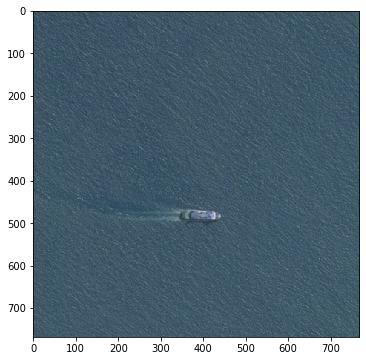

In [30]:
plt.figure(figsize=(6,6))
ds = imread(os.path.join(training_dir, image_fps[0])) # read  image from filepath 
_ = plt.imshow(ds)


In [31]:
original_size = ds.shape[0]
original_size

768

Create and prepare the training dataset using the DetectorDataset class.

In [32]:
%%time
# prepare the training dataset
dataset_train = DetectorDataset(image_fps_train, image_annotations, original_size, original_size)
dataset_train.prepare()

CPU times: user 4min 7s, sys: 2.84 s, total: 4min 10s
Wall time: 4min 11s


In [33]:
%%time
# prepare the validation dataset
dataset_val = DetectorDataset(image_fps_val, image_annotations, original_size, original_size)
dataset_val.prepare()

CPU times: user 6.71 s, sys: 46.5 ms, total: 6.76 s
Wall time: 6.78 s


Display a random image with bounding boxes

(768, 768, 3)
../data/train_v2/d6c509605.jpg
[1 1 1 1 1 1 1 1]


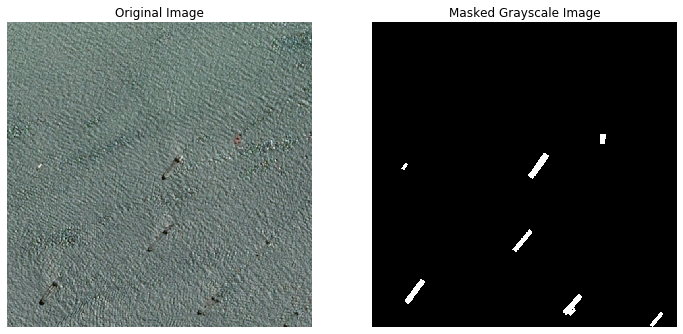

In [34]:
# Load and display random sample and their bounding boxes

class_ids = [0]
while class_ids[0] == 0:  ## look for a mask
    image_id = random.choice(dataset_val.image_ids)
    image_fp = dataset_val.image_reference(image_id)
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)

print(image.shape)

plt.figure(figsize=(12, 12))
plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Masked Grayscale Image')
masked = np.zeros(image.shape[:2])
for i in range(mask.shape[2]):
    masked += mask[:, :, i] ## * image[:, :, 0]
plt.imshow(masked, cmap='gray')
plt.axis('off')

print(image_fp)
print(class_ids)

Now it's time to train the model. Note that training even a basic model can take a few hours.
Note: the following model is for demonstration purpose only. We have limited the training to one epoch, and have set nominal values for the Detector Configuration to reduce run-time.

dataset_train and dataset_val are derived from DetectorDataset
DetectorDataset loads images from image filenames and masks from the annotation data
model is Mask-RCNN

In [35]:
model = modellib.MaskRCNN(mode="training", config=config, model_dir=root_dir)

# Exclude the last layers because they require a matching
# number of classes
model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=[
    "mrcnn_class_logits", "mrcnn_bbox_fc",
    "mrcnn_bbox", "mrcnn_mask"])


In [36]:
LEARNING_RATE = 0.003

# Train Mask-RCNN Model 
import warnings 
warnings.filterwarnings("ignore")


In [37]:
%%time
## train heads with higher lr to speedup the learning
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE*2,
            epochs=2,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history = model.keras_model.history.history


Starting at epoch 0. LR=0.006

Checkpoint Path: ../working/airbus20200526T1611/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (Ti

In [43]:
%%time
model.train(dataset_train, dataset_val,
            learning_rate=LEARNING_RATE/2,
            epochs=6,
            layers='heads',
            augmentation=None)  ## no need to augment yet

history_2 = model.keras_model.history.history
for k in history_2: history[k] = history[k] + history_2[k]



Starting at epoch 2. LR=0.0015

Checkpoint Path: ../working/airbus20200526T1611/mask_rcnn_airbus_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (T

In [44]:
epochs = range(1, len(history['loss'])+1)
pd.DataFrame(history, index=epochs)

val_loss  val_rpn_class_loss  val_rpn_bbox_loss  val_mrcnn_class_loss  \
1  10.692458            7.067659           2.007951              0.645690   
2   9.988640            7.133666           1.447277              0.363302   
3  11.217390            8.207664           1.903139              0.360863   
4   6.535127            4.135729           1.094112              0.560616   
5   6.038901            3.584422           1.390730              0.302495   
6   5.527404            3.208292           1.199579              0.488838   

   val_mrcnn_bbox_loss  val_mrcnn_mask_loss      loss  rpn_class_loss  \
1             0.467206             0.503950  8.209456        4.934248   
2             0.508482             0.535910  8.076327        5.226658   
3             0.383455             0.362267  5.155658        2.649591   
4             0.346258             0.398409  5.522039        3.206382   
5             0.357151             0.404101  5.886938        3.463476   
6             0.289244             0.341450  6.223932        3.868730   

   rpn_bbox_loss  mrcnn_class_loss  mrcnn_bbox_loss  mrcnn_mask_loss  
1       1.790188          0.602896         0.447587         0.434535  
2       1.571754          0.438637         0.411799         0.427477  
3       1.310765          0.421441         0.381573         0.392287  
4       1.242898          0.382268         0.323297         0.367192  
5       1.255707          0.441028         0.333000         0.393726  
6       1.258902          0.377013         0.322916         0.396368

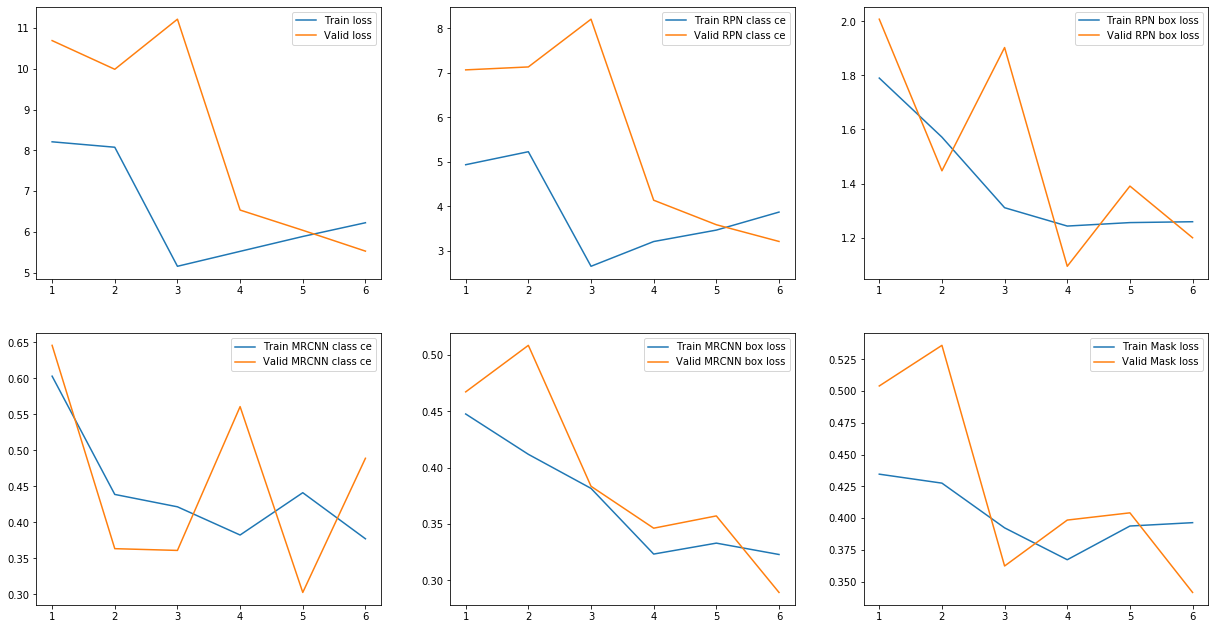

In [45]:
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [52]:
best_epoch = np.argmin(history["val_loss"])
score = history["val_loss"][best_epoch]
print(f'Best Epoch: {best_epoch+1}, val_loss: {score}')

Best Epoch: 6, val_loss: 5.527404058456421


In [53]:
# select trained model 
dir_names = next(os.walk(model.model_dir))[1]
key = config.NAME.lower()
dir_names = filter(lambda f: f.startswith(key), dir_names)
dir_names = sorted(dir_names)

if not dir_names:
    import errno
    raise FileNotFoundError(
        errno.ENOENT,
        "Could not find model directory under {}".format(self.model_dir))

fps = []
# Pick last directory
for d in dir_names: 
    dir_name = os.path.join(model.model_dir, d)
    # Find the last checkpoint
    checkpoints = next(os.walk(dir_name))[2]
    checkpoints = filter(lambda f: f.startswith("mask_rcnn"), checkpoints)
    checkpoints = sorted(checkpoints)
    if not checkpoints:
        print('No weight files in {}'.format(dir_name))
    else:
        checkpoint = os.path.join(dir_name, checkpoints[best_epoch])
        fps.append(checkpoint)

model_path = sorted(fps)[-1]
print('Found model {}'.format(model_path))

No weight files in ../working/airbus20200525T2138
No weight files in ../working/airbus20200526T1601
Found model ../working/airbus20200526T1611/mask_rcnn_airbus_0006.h5


In [54]:
class InferenceConfig(DetectorConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=root_dir)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ../working/airbus20200526T1611/mask_rcnn_airbus_0006.h5
Re-starting from epoch 6


In [55]:
# set color for class
def get_colors_for_class_ids(class_ids):
    colors = []
    for class_id in class_ids:
        if class_id == 1:
            colors.append((.941, .204, .204))
    return colors


*** No instances to display *** 



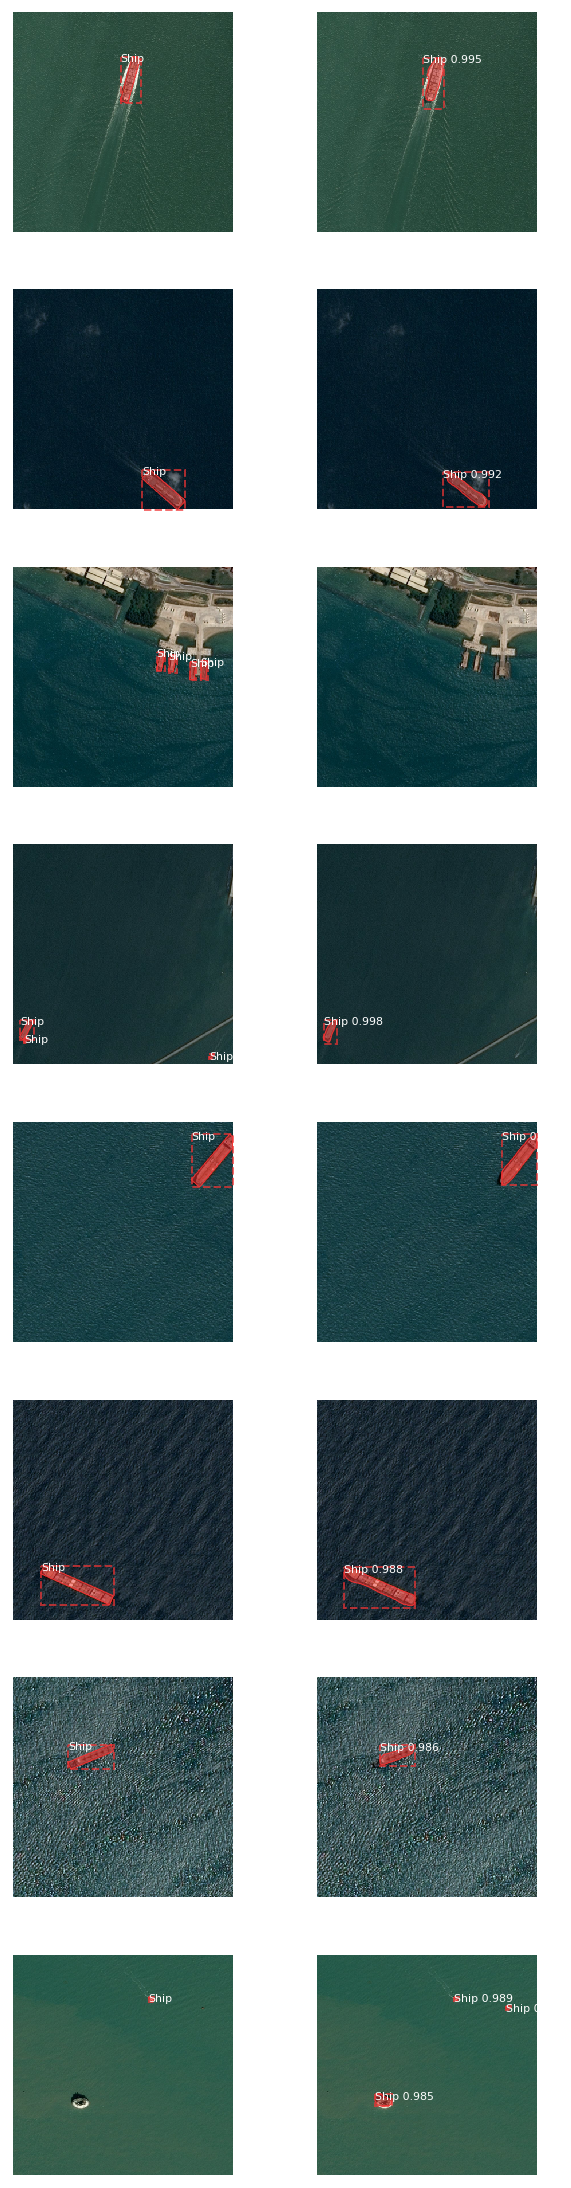

In [57]:
# Show few example of ground truth vs. predictions on the validation dataset 
dataset = dataset_val
fig = plt.figure(figsize=(10, 40))

for i in range(8):

    image_id = random.choice(dataset.image_ids)
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    
#     print(original_image.shape)
    plt.subplot(8, 2, 2*i + 1)
    visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                                dataset.class_names,
                                colors=get_colors_for_class_ids(gt_class_id), ax=fig.axes[-1])
    
    plt.subplot(8, 2, 2*i + 2)
    results = model.detect([original_image]) #, verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset.class_names, r['scores'], 
                                colors=get_colors_for_class_ids(r['class_ids']), ax=fig.axes[-1])

Final steps - Create the filtered submission file

In [61]:
# Get filenames of test dataset images
test_image_fps = test_names
test_names

['c677b923d.jpg',
 '70f933b1a.jpg',
 '6efd40b2c.jpg',
 '75004aaf3.jpg',
 '7ae269875.jpg',
 '960395192.jpg',
 'c5e400184.jpg',
 'ede1be4c6.jpg',
 '46274a246.jpg',
 '812ccd874.jpg',
 '4b9a90f8b.jpg',
 '53ed6aad3.jpg',
 '45305db1b.jpg',
 '291cda503.jpg',
 'a99d01e1b.jpg',
 'a1a93c08b.jpg',
 'b89f032c3.jpg',
 '613bb1f62.jpg',
 '63a45bf6a.jpg',
 'c23a9a0af.jpg',
 '19f389c5e.jpg',
 '62d608b1f.jpg',
 '9b7f43de6.jpg',
 'f3068ad02.jpg',
 '382020b7e.jpg',
 '457f8b5a2.jpg',
 '01f579dc1.jpg',
 '8bfa9d0a9.jpg',
 '990afd785.jpg',
 '2e77b6060.jpg',
 'c6ddc306c.jpg',
 'ff9785b14.jpg',
 'fddf484fe.jpg',
 '8e742aecb.jpg',
 'e6cf1a48c.jpg',
 '8d483c31f.jpg',
 '07813b118.jpg',
 'dfe4866ad.jpg',
 '851229ec8.jpg',
 '7eb47d693.jpg',
 '872fbd0c6.jpg',
 '56aef15e3.jpg',
 '91804042d.jpg',
 '7cf343d45.jpg',
 '11632a6e8.jpg',
 'fe426db03.jpg',
 '2c89207ea.jpg',
 '7cac54e8c.jpg',
 'e568a88ef.jpg',
 '42afaaa6b.jpg',
 '0c71ad9ea.jpg',
 '24ac9a02a.jpg',
 'a70442601.jpg',
 '3fac487c3.jpg',
 'fe9c01b45.jpg',
 '0ed1393c

In [70]:
# Make predictions on test images, write out sample submission
def predict(image_fps, filepath='submission.csv', min_conf=config.DETECTION_MIN_CONFIDENCE):
    # assume square image
    resize_factor = original_size / config.IMAGE_SHAPE[0]
    #resize_factor = ORIG_SIZE
    with open(filepath, 'w') as file:
        file.write("ImageId,EncodedPixels\n")

        for image_id in tqdm(image_fps):
            found = False

#             if image_id not in test_names_nothing:
            image = imread(os.path.join(test_dir, image_id))
                # If grayscale. Convert to RGB for consistency.
            if len(image.shape) != 3 or image.shape[2] != 3:
                    image = np.stack((image,) * 3, -1)
#                 image, window, scale, padding, crop = utils.resize_image(
#                     image,
#                     min_dim=config.IMAGE_MIN_DIM,
#                     min_scale=config.IMAGE_MIN_SCALE,
#                     max_dim=config.IMAGE_MAX_DIM,
#                     mode=config.IMAGE_RESIZE_MODE)

            results = model.detect([image])
            r = results[0]

            assert( len(r['rois']) == len(r['class_ids']) == len(r['scores']) )
            if len(r['rois']) == 0:
                pass  ## no ship
            else:
                num_instances = len(r['rois'])

                for i in range(num_instances):
                    if r['scores'][i] > min_conf:
#                             print(r['scores'][i], r['rois'][i], r['masks'].shape, np.sum(r['masks'][...,i]))
#                             plt.imshow(r['masks'][...,i], cmap=get_cmap('jet'))
                        file.write(image_id + "," + rle_encode(r['masks'][...,i]) + "\n")
                        found = True

            if not found:
                file.write(image_id + ",\n")  ## no ship

In [71]:
submission_fp = os.path.join(root_dir, 'submission.csv')
predict(test_image_fps, filepath=submission_fp)
print(submission_fp)

100%|██████████| 15606/15606 [4:21:03<00:00,  1.00s/it]  

../working/submission.csv


In [72]:
sub = pd.read_csv(submission_fp)
print(sub.EncodedPixels.isnull().sum(), sub.ImageId.nunique(), sub.EncodedPixels.isnull().sum()/sub.ImageId.nunique())
sub.head(50)

13109 15606 0.83999743688325


ImageId                                      EncodedPixels
0   c677b923d.jpg                                                NaN
1   70f933b1a.jpg                                                NaN
2   6efd40b2c.jpg                                                NaN
3   75004aaf3.jpg                                                NaN
4   7ae269875.jpg                                                NaN
5   960395192.jpg                                                NaN
6   c5e400184.jpg                                                NaN
7   ede1be4c6.jpg                                                NaN
8   46274a246.jpg                                                NaN
9   812ccd874.jpg                                                NaN
10  4b9a90f8b.jpg                                                NaN
11  53ed6aad3.jpg                                                NaN
12  45305db1b.jpg                                                NaN
13  291cda503.jpg                                                NaN
14  a99d01e1b.jpg                                                NaN
15  a1a93c08b.jpg                                                NaN
16  b89f032c3.jpg                                                NaN
17  613bb1f62.jpg  303675 2 304441 7 305207 11 305974 13 306741 1...
18  63a45bf6a.jpg                                                NaN
19  c23a9a0af.jpg                                                NaN
20  19f389c5e.jpg                                                NaN
21  62d608b1f.jpg                                                NaN
22  9b7f43de6.jpg                                                NaN
23  f3068ad02.jpg                                                NaN
24  382020b7e.jpg                                                NaN
25  457f8b5a2.jpg                                                NaN
26  01f579dc1.jpg                                                NaN
27  8bfa9d0a9.jpg                                                NaN
28  990afd785.jpg                                                NaN
29  2e77b6060.jpg  1294 6 2063 9 2831 13 3600 14 4369 18 5139 20 ...
30  c6ddc306c.jpg                                                NaN
31  ff9785b14.jpg                                                NaN
32  fddf484fe.jpg  196860 7 197624 16 198391 18 199158 20 199925 ...
33  fddf484fe.jpg  530095 11 530861 15 531627 19 532394 22 533161...
34  fddf484fe.jpg  271867 4 272632 7 273399 8 274165 11 274931 13...
35  8e742aecb.jpg                                                NaN
36  e6cf1a48c.jpg                                                NaN
37  8d483c31f.jpg                                                NaN
38  07813b118.jpg  457286 3 458052 7 458820 8 459588 9 460356 9 4...
39  dfe4866ad.jpg                                                NaN
40  851229ec8.jpg  123402 5 124170 9 124937 11 125705 12 126473 1...
41  7eb47d693.jpg                                                NaN
42  872fbd0c6.jpg                                                NaN
43  56aef15e3.jpg                                                NaN
44  91804042d.jpg                                                NaN
45  7cf343d45.jpg  411583 1 412350 5 413117 8 413884 10 414652 10...
46  11632a6e8.jpg                                                NaN
47  fe426db03.jpg                                                NaN
48  2c89207ea.jpg                                                NaN
49  7cac54e8c.jpg                                                NaN

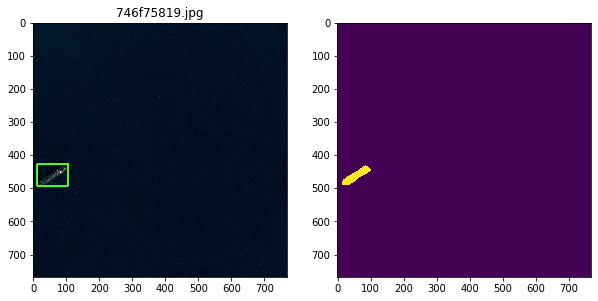

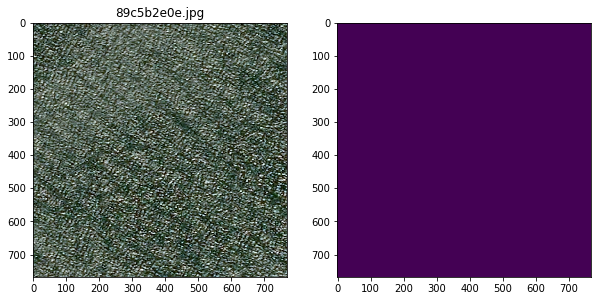

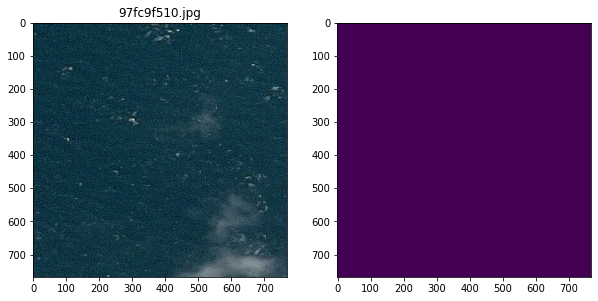

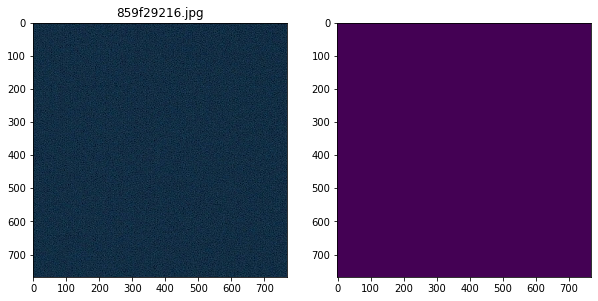

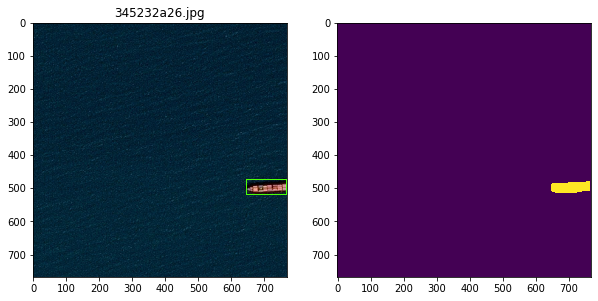

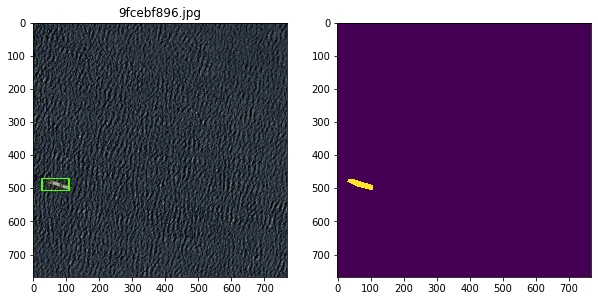

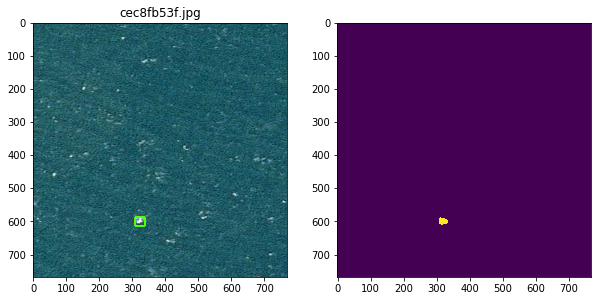

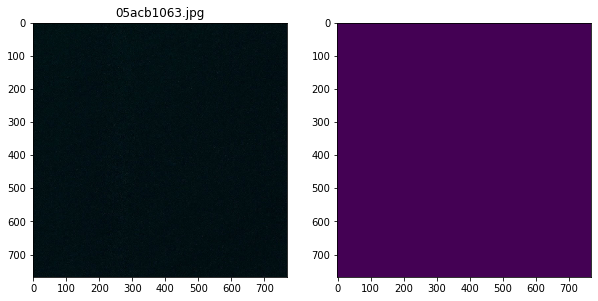

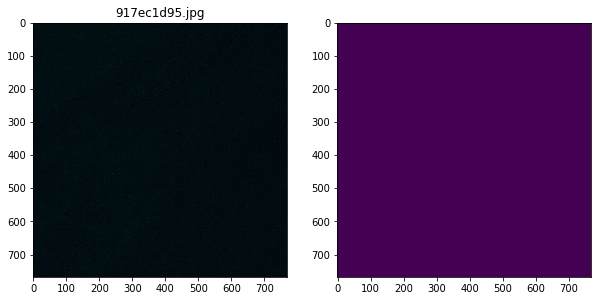

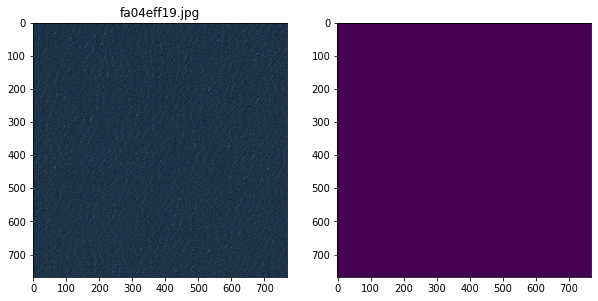

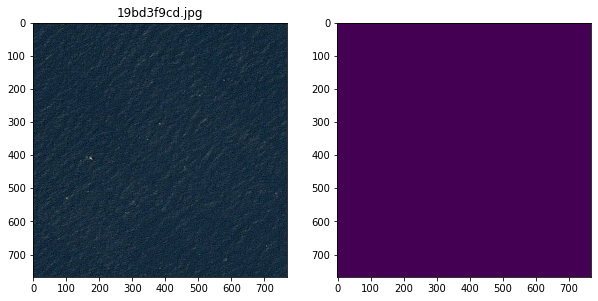

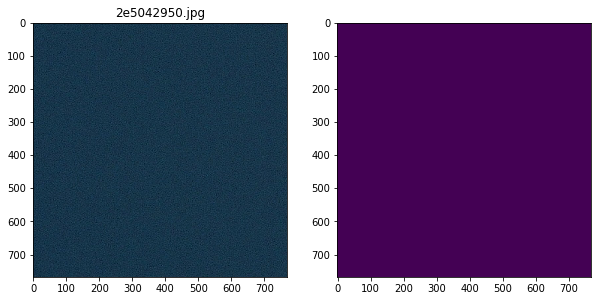

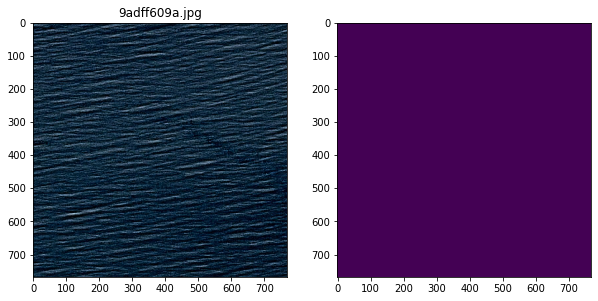

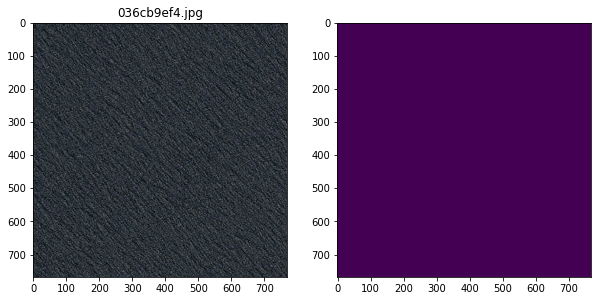

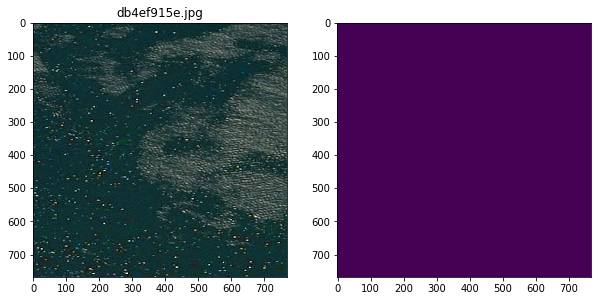

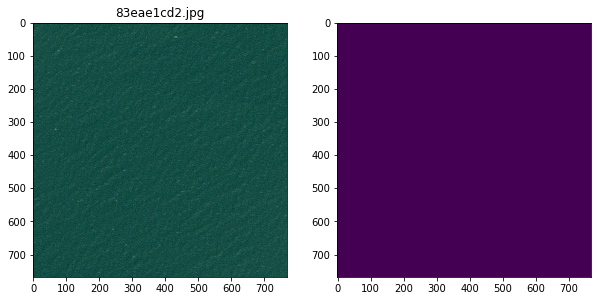

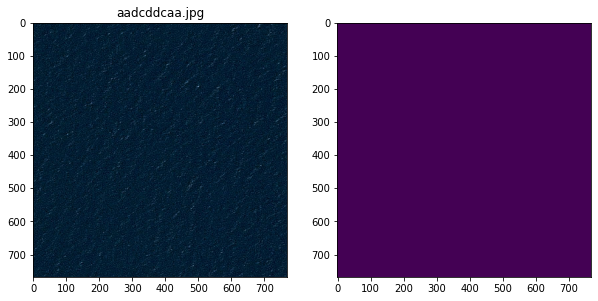

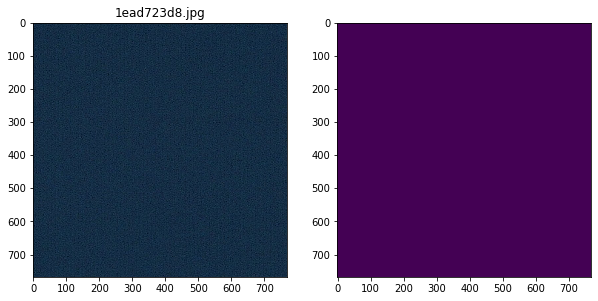

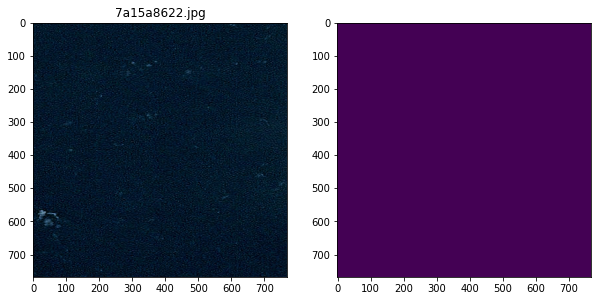

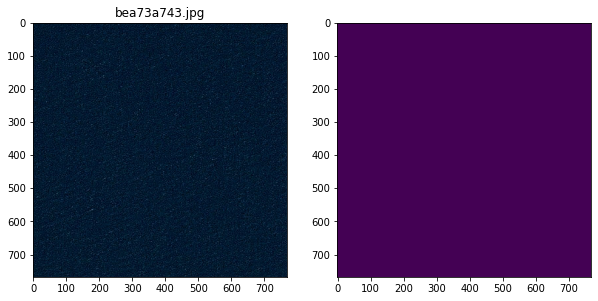

In [84]:
# show a few test image detection example
def visualize_test(): 
    image_id = random.choice(test_names)
    
    # original image
#     print(image_id)
    image = imread(os.path.join(test_dir, image_id))
    
    # assume square image 
    resize_factor = 1 ## ORIG_SIZE / config.IMAGE_SHAPE[0]
    
    # If grayscale. Convert to RGB for consistency.
    if len(image.shape) != 3 or image.shape[2] != 3:
        image = np.stack((image,) * 3, -1) 
#     image, window, scale, padding, crop = utils.resize_image(
#         image,
#         min_dim=config.IMAGE_MIN_DIM,
#         min_scale=config.IMAGE_MIN_SCALE,
#         max_dim=config.IMAGE_MAX_DIM,
#         mode=config.IMAGE_RESIZE_MODE)

    results = model.detect([image])
    r = results[0]
    for bbox in r['rois']: 
#         print(bbox)
        x1 = int(bbox[1] * resize_factor)
        y1 = int(bbox[0] * resize_factor)
        x2 = int(bbox[3] * resize_factor)
        y2 = int(bbox[2]  * resize_factor)
        cv2.rectangle(image, (x1,y1), (x2,y2), (77, 255, 9), 3, 1)
        width = x2 - x1 
        height = y2 - y1 
#         print("x {} y {} h {} w {}".format(x1, y1, width, height))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.set_title(f"{image_id}")
    ax1.imshow(image)
#     ax2.set_title(f"{len(r['rois'])} masks if prob:{ship_detection.loc[image_id][0]:.6f}")
    ax2.imshow(masks_as_color(sub.query(f"ImageId=='{image_id}'")['EncodedPixels']))

for i in range(20):
    visualize_test()

## Submitted the test set predictions for verification and final accuracy score came to 79%!